In [14]:
import random

import pylangacq
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, cohen_kappa_score, balanced_accuracy_score


import warnings
warnings.filterwarnings("ignore")

In [86]:
# only once run for download WordNet or update
import nltk
nltk.download('wordnet', download_dir='./')
nltk.data.path.append('./')

[nltk_data] Downloading package wordnet to ./...
[nltk_data]   Unzipping corpora/wordnet.zip.


check the abnormal result of CHILDES by 10 times sampling corpus

In [15]:
# load sub-corporas
brown = pylangacq.read_chat("./corpora/CHILDES/Brown.zip")
belf = pylangacq.read_chat("./corpora/CHILDES/Belfast.zip")
crutt=pylangacq.read_chat("./corpora/CHILDES/Cruttenden.zip")
fletcher=pylangacq.read_chat("./corpora/CHILDES/Fletcher.zip")
forr=pylangacq.read_chat("./corpora/CHILDES/Forrester.zip")
gath=pylangacq.read_chat("./corpora/CHILDES/Gathburn.zip")
howe=pylangacq.read_chat("./corpora/CHILDES/Howe.zip")
kelly=pylangacq.read_chat("./corpora/CHILDES/KellyQuigley.zip")
korman=pylangacq.read_chat("./corpora/CHILDES/Korman.zip")
lara=pylangacq.read_chat("./corpora/CHILDES/Lara.zip")
manc=pylangacq.read_chat("./corpora/CHILDES/Manchester.zip")
nuff=pylangacq.read_chat("./corpora/CHILDES/Nuffield.zip")
quigley=pylangacq.read_chat("./corpora/CHILDES/QuigleyMcNally.zip")
sekali=pylangacq.read_chat("./corpora/CHILDES/Sekali.zip")
smith=pylangacq.read_chat("./corpora/CHILDES/Smith.zip")
tommer=pylangacq.read_chat("./corpora/CHILDES/Tommerdahl.zip")

# link up sub-corporas
corpora = [brown, belf, crutt, fletcher, forr, gath, howe, kelly, korman, lara, manc, nuff, quigley, sekali, smith, tommer]
reader = pylangacq.Reader()
for item in corpora:
    reader.append(item)

# preparation sample for 5.7m, 2.4m, 1m
words = reader.words()
childes_df = pd.Series(words)
random_seed = 7

In [53]:
# inherit features from Gold Standard dataset
GS_all_agreed = pd.read_csv('./sampled_count/GS_All_Agreed.csv', index_col=0)
features_target = ['Synsets','domain_x',
                   'ngrams_last_mean',
                   'nrdirhypers_x',
                   'nrhypos_x',
                   'nrpartrels_normalised_x',
                   'depthfromtopsynset_normalised_x',
                   'glosslength_normalised_x',
                   'minwordlength_x',
                   'nroflemmas_x',
                   'polyscore_max_x',
                   'vote_x']
GS_adopt = GS_all_agreed[features_target]

# extract norms from synsets
GS_adopt['norm'] = GS_adopt['Synsets'].str.split("'").str[1].str.split('.').str[0]
GS_adopt = GS_adopt.set_index('norm').reset_index()


In [96]:
# matching norms with corpora
def sum_lemmas(norm, corpora):
    # search norm in WordNet
    synsets_list = wordnet.synsets(norm)
    lemmas = []
    feq_count = 0
    for synset in synsets_list:
        # extract lemmas from every synset
        lemmas += [str(lemma.name()) for lemma in synset.lemmas()]
    for lemma in lemmas:
        # check each lemma in corpora
        feq_count += corpora.loc[lemma == corpora.index].to_numpy().sum()

    return feq_count

In [55]:
# define features and target
features = ['ngrams_last_mean',
            'nrdirhypers_x',
            'nrhypos_x',
            'nrpartrels_normalised_x',
            'depthfromtopsynset_normalised_x',
            'glosslength_normalised_x',
            'minwordlength_x',
            'nroflemmas_x',
            'polyscore_max_x']
target = ['vote_x'] # nb / b

In [56]:
# split training set and testing set using K-Flod
def global_model_test(dataset, feature, sized_corpora, target):
    K = 10
    random_seed = 7 # R
    data = dataset.reset_index()
    feature_list = feature + [sized_corpora]
    X = data[feature_list]
    y = data[target]

    K_Flod = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_seed)
    K_Flod.get_n_splits(X, y)
    cohen_kappa = []
    balanced_acc = []
    for train_index, test_index in K_Flod.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # SMOTE algorithm
        smote = SMOTE(random_state=random_seed, k_neighbors=2)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # define random forest model
        rf = RandomForestClassifier(random_state=random_seed, max_features='sqrt', n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_depth=50, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train)

        # predict and make score
        pipeline = make_pipeline(smote, rf)
        y_pred = pipeline.predict(X_test)

        kappa = cohen_kappa_score(y_test, y_pred)
        cohen_kappa.append(kappa)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        balanced_acc.append(balanced_accuracy)

    results = classification_report(y_test, y_pred, output_dict=True)
    results = pd.DataFrame(results).transpose()

    results['cohen kappa / 10'] = np.mean(cohen_kappa)
    results['balanced acc / 10'] = np.mean(balanced_acc)
    results['global'] = 5

    # importance of features
    importance = rf.feature_importances_
    importance = pd.DataFrame([features, importance]).transpose()
    importance = importance.rename(columns={0:'feature', 1:'importance'}).sort_values('importance', ascending=False)

    return results, importance

In [160]:
# define a function to perform several times sampling
def multiSample(n):
    result_dict = {}
    for time in range(n):
        childes_5_7m = childes_df.sample(n=5700000, replace=True)
        childes_2_4m = childes_df.sample(n=2400000)
        childes_1m = childes_df.sample(n=1000000)

        # create a word count from dictionary into dataframe
        # addition: convert all words into low case
        childes_5_7m_freq = nltk.FreqDist(word.lower() for word in childes_5_7m)
        childes_5_7m_df = pd.DataFrame.from_dict(childes_5_7m_freq, orient='index').reset_index().rename(columns={0: 'CHILDES_Count', 'index':'norm'}).set_index('norm')
        childes_2_4m_freq = nltk.FreqDist(word.lower() for word in childes_2_4m)
        childes_2_4m_df = pd.DataFrame.from_dict(childes_2_4m_freq, orient='index').reset_index().rename(columns={0: 'CHILDES_Count', 'index':'norm'}).set_index('norm')
        childes_1m_freq = nltk.FreqDist(word.lower() for word in childes_1m)
        childes_1m_df = pd.DataFrame.from_dict(childes_1m_freq, orient='index').reset_index().rename(columns={0: 'CHILDES_Count', 'index':'norm'}).set_index('norm')

        # childes_rel_sum: The sum of all instances of each lemma per synset in the CHILDES corpus, devided by the total number of words in the corpus
        total_count_1m = childes_1m_df['CHILDES_Count'].sum()
        GS_adopt['childes_1m_rel_sum'] = GS_adopt['norm'].apply(lambda norm: sum_lemmas(norm, childes_1m_df)/total_count_1m)
        total_count_2_4m = childes_2_4m_df['CHILDES_Count'].sum()
        GS_adopt['childes_2_4m_rel_sum'] = GS_adopt['norm'].apply(lambda norm: sum_lemmas(norm, childes_2_4m_df)/total_count_2_4m)
        total_count_5_7m = childes_5_7m_df['CHILDES_Count'].sum()
        GS_adopt['childes_5_7m_rel_sum'] = GS_adopt['norm'].apply(lambda norm: sum_lemmas(norm, childes_5_7m_df)/total_count_5_7m)

        # GlobalModel test
        result_dict[time] = {'1M':{}, '2_4M':{}, '5_7M':{}}
        sized_corpora = 'childes_1m_rel_sum'
        result_dict[time]['1M']['results'], result_dict[time]['1M']['importance'] = global_model_test(GS_adopt, features, sized_corpora, target)
        sized_corpora = 'childes_2_4m_rel_sum'
        result_dict[time]['2_4M']['results'], result_dict[time]['2_4M']['importance'] = global_model_test(GS_adopt, features, sized_corpora, target)
        sized_corpora = 'childes_5_7m_rel_sum'
        result_dict[time]['5_7M']['results'], result_dict[time]['5_7M']['importance'] = global_model_test(GS_adopt, features, sized_corpora, target)

    return result_dict

In [163]:
multiResults = multiSample(10)

In [189]:
np.save('10_times_sampling_CHILDES.npy', multiResults)

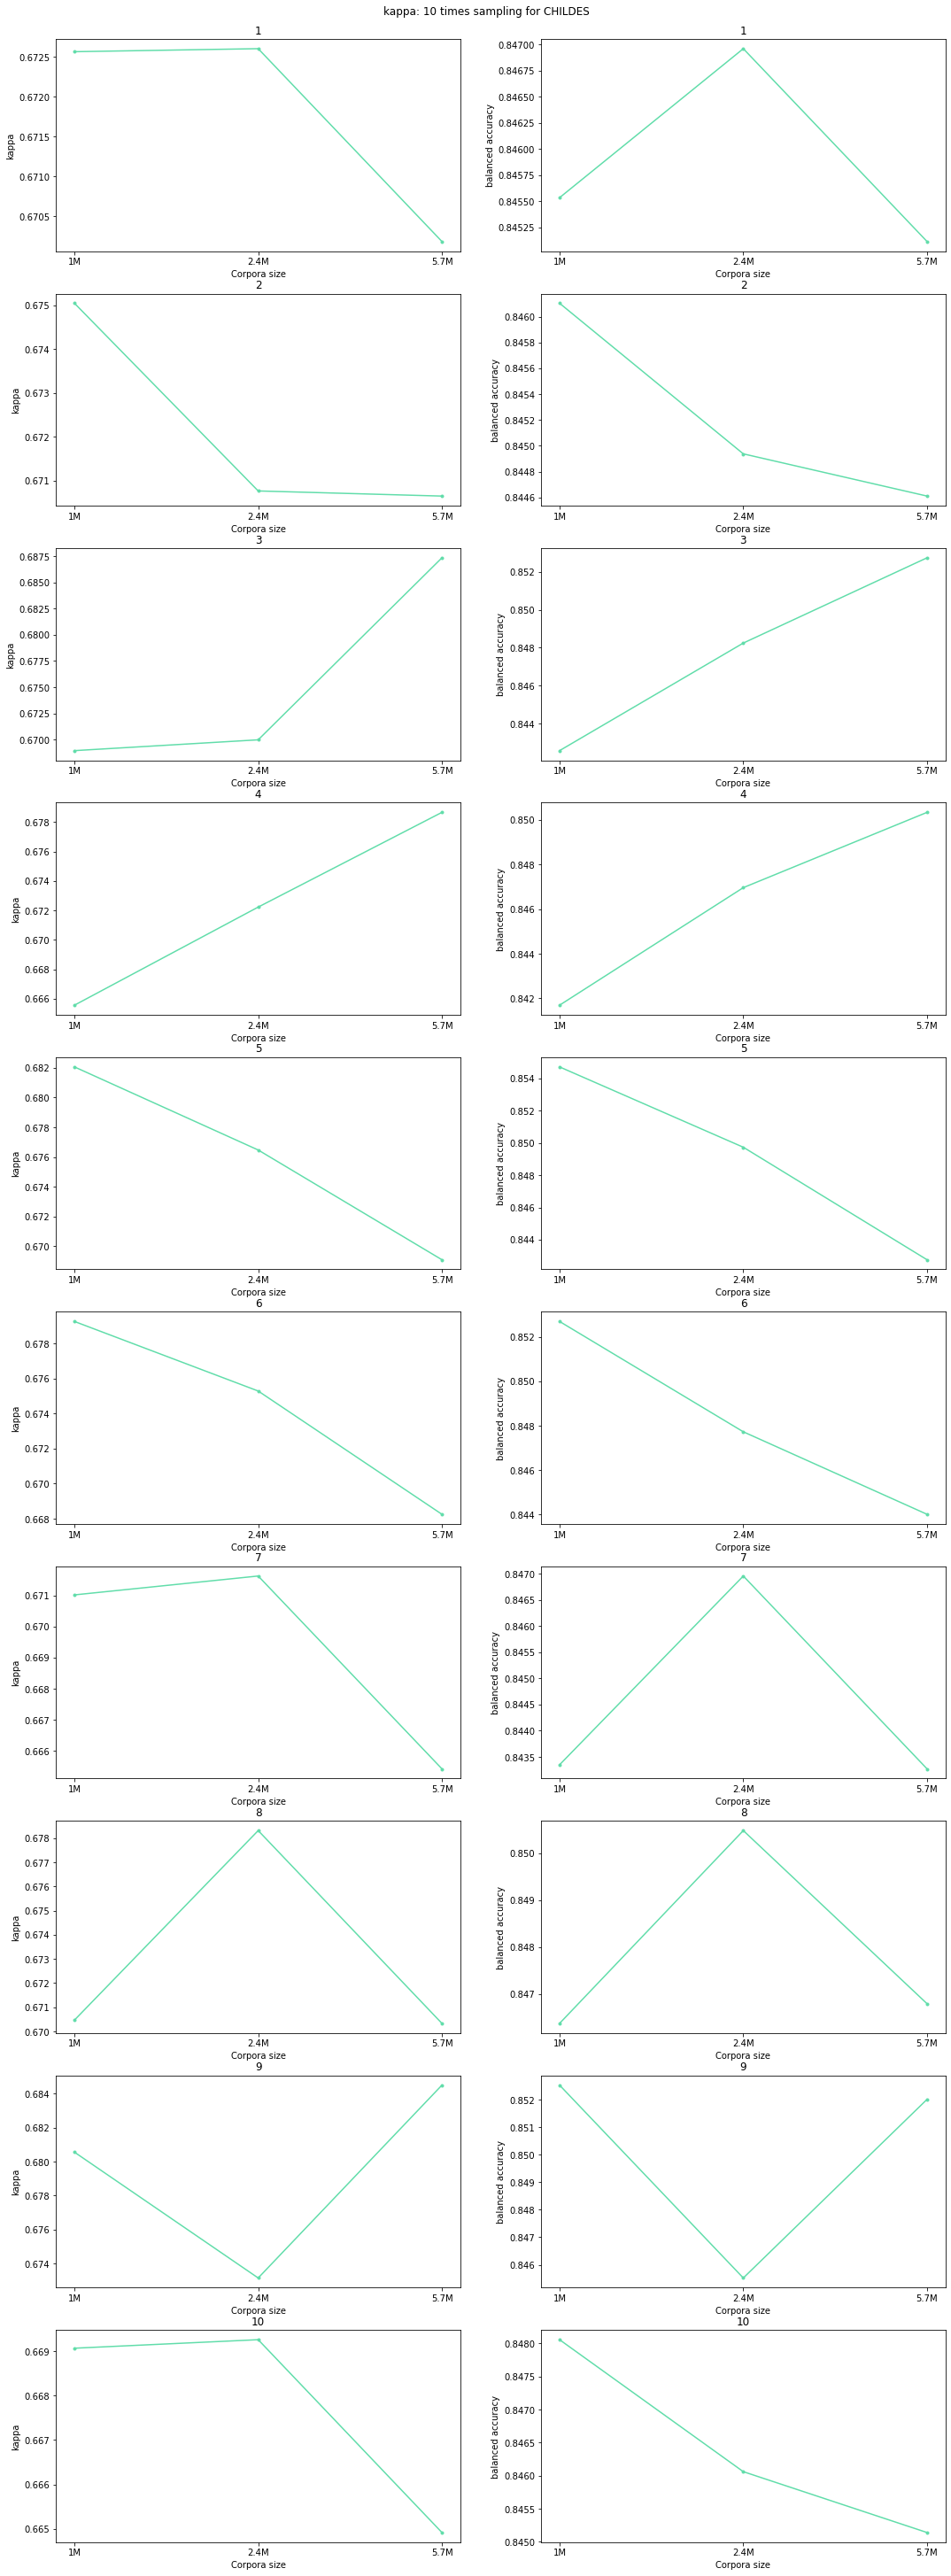

In [198]:
# plot
import matplotlib.pyplot as plt

# kappa
x = ['1M', '2.4M', '5.7M']
fig, axs = plt.subplots(10, 2, figsize=(18,52))
fig.suptitle('kappa: 10 times sampling for CHILDES', y=0.89)
for time in range(10):
    sub_dict = multiResults[time]
    kappa = [sub_dict['1M']['results']['cohen kappa / 10'][0], sub_dict['2_4M']['results']['cohen kappa / 10'][0], sub_dict['5_7M']['results']['cohen kappa / 10'][0]]
    acc = [sub_dict['1M']['results']['balanced acc / 10'][0], sub_dict['2_4M']['results']['balanced acc / 10'][0], sub_dict['5_7M']['results']['balanced acc / 10'][0]]
    axs[time, 0].plot(x, kappa, marker='.', color='#61DDAA')
    axs[time, 0].set(xlabel='Corpora size', ylabel='kappa', title=str(time+1))
    axs[time, 1].plot(x, acc, marker='.', color='#61DDAA')
    axs[time, 1].set(xlabel='Corpora size', ylabel='balanced accuracy', title=str(time+1))